# scratch work

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt

import mpmath as mpm
from mpmath import matrix, mpf

mpm.mp.dps = 75

from jorbit.utils.doubledouble import DoubleDouble, dd_sum, dd_sqrt, dd_max, dd_norm
from jorbit.utils.generate_coefficients import create_iasnn_constants

from jorbit.utils.doubledouble import DoubleDouble, dd_sum, dd_sqrt, dd_max, dd_norm
from jorbit.integrators.iasnn_dd_prec import (
    setup_iasnn_integrator,
    step,
    _refine_b_and_g,
)

from jorbit.integrators.iasnn_arbitrary_prec import precompute
from jorbit.integrators.iasnn_arbitrary_prec import step as step_mp

In [2]:
steps_per_orbit = 100
n_internal_points = 7

pre = precompute(n_internal_points)
b_x_denoms, b_v_denoms, h, r, c, d = pre
x0 = matrix([["1.0", "0", "0"]])
v0 = matrix([["0", "1.0", "0"]])
a0 = matrix([["-1.0", "0", "0"]])
b = mpm.ones(n_internal_points, 3)

dt = mpf("2") * mpm.pi / mpf(str(steps_per_orbit))

for i in tqdm(range(steps_per_orbit)):
    x0, v0, b = step_mp(x0, v0, b, dt, pre)
x0 - matrix([["1.0", "0", "0"]])

100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


matrix(
[['1.94760166400892643990740087930692533963591502306510923305492240938400503599e-35', '-9.13598750383024194556124305126853116770389002898237015371525892080499150982e-35', '-1.55246816266709604196987091799171886434594537136526767249557768561412831503e-80']])

In [3]:
precompued_setup_7 = setup_iasnn_integrator(n_internal_points=7)
x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
b = DoubleDouble(jnp.zeros((7, 1, 3), dtype=jnp.float64))
dt = DoubleDouble.from_string(str(dt))

for i in tqdm(range(int(steps_per_orbit))):
    x0, v0, b = step(x0, v0, b, dt, precompued_setup_7)
x0

100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


DoubleDouble([[1.00000000e+00 5.53897452e-31 0.00000000e+00]], [[-1.61007743e-31  0.00000000e+00  0.00000000e+00]])

In [22]:
internal_pts = jnp.arange(4, 11)

precomputed = []
for pts in internal_pts:
    precomputed.append(setup_iasnn_integrator(n_internal_points=int(pts)))

steps_per_orbit = list(set([int(i) for i in jnp.logspace(0, 3, 20)]))
steps_per_orbit.sort()

errs = jnp.zeros((7, len(steps_per_orbit)))
for s in tqdm(steps_per_orbit):
    dt = mpf("2") * mpm.pi / mpf(str(s))
    dt = DoubleDouble.from_string(str(dt))

    for pts in internal_pts:
        x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
        v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
        b = DoubleDouble(jnp.zeros((pts, 1, 3), dtype=jnp.float64))
        for i in range(int(s)):
            x0, v0, b = step(x0, v0, b, dt, precomputed[pts - 4])
        errs = errs.at[pts - 4, steps_per_orbit.index(s)].set(
            dd_norm(x0 - DoubleDouble(jnp.array([[1.0, 0, 0]]))).hi
        )

100%|██████████| 18/18 [02:22<00:00,  7.91s/it]


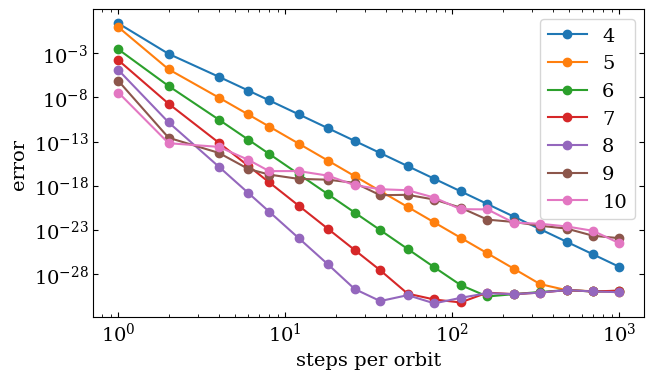

In [23]:
fig, ax = plt.subplots()
for pts in internal_pts:
    ax.plot(steps_per_orbit, errs[pts - 4], "o-", label=str(pts))
ax.set(xlabel="steps per orbit", ylabel="error", xscale="log", yscale="log")
ax.legend()